## Artificial Intelligence | 4022 | Dr. Fadaei
## Assignment #05
***
### Amirreza Akbari | 810899045
### 1402/03/18

## Install & Import Libraries

In [13]:
import importlib.util

required_libraries = ["pandas", "matplotlib", "nltk", "emoji"]

for lib in required_libraries:
    if importlib.util.find_spec(lib) is None:
        # Install the library
        !pip install {lib}

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
import emoji


## Part 0: Data Preparation

### 1. Preprocessing Function

In [14]:
# Define the required NLTK data
nltk_data = {
    'stopwords': 'corpora/stopwords',
    'punkt': 'tokenizers/punkt',
    'wordnet': 'corpora/wordnet.zip'
}

# Ensure all necessary NLTK data is downloaded
for data, resource in nltk_data.items():
    try:
        nltk.data.find(resource)
    except LookupError:
        nltk.download(data)

# Define stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    
    # Remove punctuation marks
    text = re.sub(r'[^\w\s]', ' ', text)
    
    # Remove numbers
    text = re.sub(r'\d+', ' ', text)
    
    # Remove links
    text = re.sub(r'http\S+|www\S+|https\S+', ' ', text, flags=re.MULTILINE)
    
    # Remove user references
    text = re.sub(r'@\w+', ' ', text)
    
    # Remove emojis
    text = emoji.demojize(text)
    
    # Unify white spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Eliminate non-word phrases
    text = re.sub(r'\W', ' ', text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stop words and lemmatize the tokens
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words and token.isalpha()]
    
    return tokens


**Converting the text to lowercase**

Advantages:
- **Normalization:** Converting text to lowercase standardizes the text, ensuring that words like "Apple" and "apple" are treated as the same word. This reduces the complexity and variability in the text data, making it easier to process and analyze.
- **Simplified Matching:** It simplifies string matching and comparisons, as we don't have to account for different capitalizations of the same word. This is particularly useful in natural language processing tasks where consistency is crucial.
- **Reduced Vocabulary Size:** By converting text to lowercase, the vocabulary size is reduced, which can help in improving the efficiency of the model. A smaller vocabulary means fewer parameters to learn, which can lead to faster training times and less computational resource usage.

Disadvantages:
- **Loss of Information:** Case sensitivity can sometimes carry important information, especially in Named Entity Recognition (NER) tasks. Some words may carry different meanings based on their capitalization (e.g., "Apple" (the company) vs. "apple" (the fruit)). Converting to lowercase can result in the loss of such distinctions, potentially impacting the understanding of the context.
- **Proper Nouns:** Capitalized words often represent proper nouns (names of people, places, organizations, etc.). Lowercasing these words can remove the indication that they are proper nouns, which might be relevant in some contexts.

Why We Do This Processing:
> We convert text to lowercase to simplify the text data, making it more consistent and easier to process. This step is typically done early in the preprocessing pipeline to ensure that all subsequent text manipulations operate on a normalized text format. Despite the potential loss of some context-specific information, the benefits of reducing variability and complexity in the text generally outweigh the disadvantages.

***

**Elimination of numbers**

Advantages:
- **Noise Reduction:** Numbers in text can often be irrelevant to the task at hand and may introduce noise. Removing numbers can help in focusing on the meaningful words that contribute to the understanding of the text.
- **Simplified Tokenization:** By removing numbers, the tokenization process is simplified and focused on the actual textual content. Numbers can sometimes create challenges in tokenization, especially if they are part of words or phrases.
- **Reduced Vocabulary Size:** Eliminating numbers reduces the size of the vocabulary, similar to the effect of lowercasing. This can lead to more efficient processing and potentially faster training times for machine learning models.

Disadvantages:
- **Loss of Information:** Numbers can carry significant information, especially in certain contexts (e.g., dates, quantities, measurements). Removing them can lead to the loss of potentially valuable information.
- **Contextual Importance:** In some tasks, the presence and frequency of numbers might be crucial for understanding the text (e.g., financial documents, scientific papers). Removing numbers indiscriminately can negatively impact the performance of models in such tasks.

Why We Do This Processing:
> In many NLP tasks, especially those dealing with informal text like tweets, numbers often do not contribute to the understanding of the text's sentiment or intent. Therefore, removing numbers helps in simplifying the text and reducing noise, although this step should be carefully considered based on the specific task and dataset.

***

**Hashtags**

Why We Keep Hashtags:
> Hashtags are not removed during preprocessing because they carry significant semantic information. On Twitter, hashtags are used to categorize content, highlight key themes, and connect tweets to broader conversations. They often summarize the main topic or sentiment of the tweet in a concise way.

Effect on Model Performance:
- **Improved Context Understanding:** Hashtags can provide additional context to the tweet, which is beneficial for models to understand the underlying topics or sentiments. For instance, a tweet with #MentalHealth can give a clear indication that the content is related to mental health.
- **Enhanced Feature Representation:** Including hashtags can enhance the feature representation of the text, as they can act as keywords that encapsulate the core message of the tweet. This can improve the model's ability to classify or analyze the text accurately.
- **Community and Trend Detection:** Hashtags help in identifying community-specific language and trending topics. They can be useful in understanding the social dynamics and temporal patterns in the data.

Potential Challenges:
- **Noisy Data:** Sometimes hashtags can be very specific or obscure, leading to increased noise in the data. This can potentially introduce irrelevant features if the hashtag usage is not consistent across the dataset.
- **Overfitting:** In some cases, models might overfit to specific hashtags, especially if they are very frequent or strongly correlated with particular labels. This can limit the model's generalizability to new, unseen data.


### 2. Apply Preprocessing

In [15]:
# Load dataset
file_path = 'twitter-suicidal-data.csv'
df = pd.read_csv(file_path)

# Apply preprocessing to the dataset
df['tokens'] = df['tweet'].apply(preprocess_text)

# Display 5 random tweets and their processed tokens
df_sample = df.sample(n=5)
for index, row in df_sample.iterrows():
    original_words = len(row['tweet'].split())
    processed_tokens = len(row['tokens'])
    print(f"Original tweet: {row['tweet']}")
    print(f"Processed tokens: {row['tokens']}")
    print(f"Number of words in original tweet: {original_words}")
    print(f"Number of tokens in processed tweet: {processed_tokens}")
    print()


Original tweet:  you were amazing rach thank you for the music i waited outside but you never showed up there s always the next album
Processed tokens: ['amazing', 'rach', 'thank', 'music', 'waited', 'outside', 'never', 'showed', 'always', 'next', 'album']
Number of words in original tweet: 23
Number of tokens in processed tweet: 11

Original tweet: remember that i love you 
Processed tokens: ['remember', 'love']
Number of words in original tweet: 5
Number of tokens in processed tweet: 2

Original tweet: is a pretty rad guy who knows how to make ppl laugh with his sharp wit and we can laugh at each other when i team kill him or i kill myself jumping through portals
Processed tokens: ['pretty', 'rad', 'guy', 'know', 'make', 'ppl', 'laugh', 'sharp', 'wit', 'laugh', 'team', 'kill', 'kill', 'jumping', 'portal']
Number of words in original tweet: 35
Number of tokens in processed tweet: 15

Original tweet:  tweet up no one invited me 
Processed tokens: ['tweet', 'one', 'invited']
Number of w

### 3. Distribution Box Plots

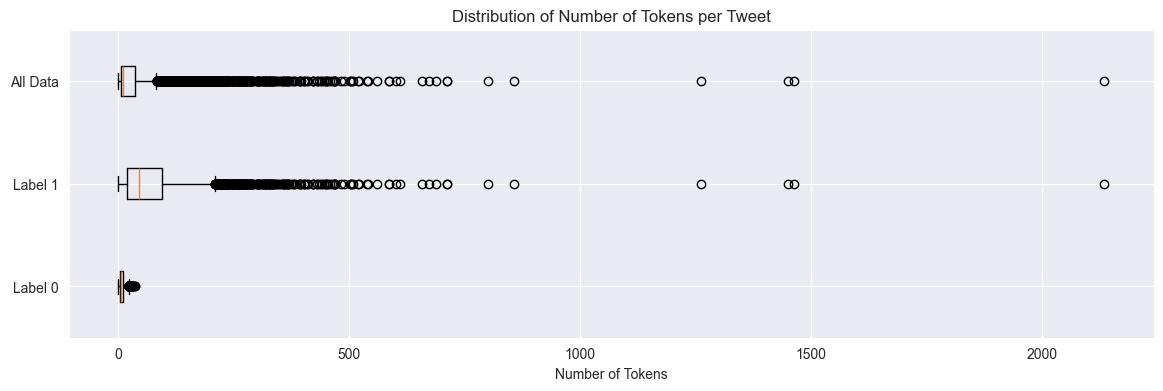

Combined Statistics:
  Statistic      Label 0      Label 1     All Data
0     count  5121.000000  3998.000000  9119.000000
1      mean     8.977543    73.830415    37.410681
2       std     6.474626    96.862836    71.917229
3       min     0.000000     0.000000     0.000000
4       25%     4.000000    19.000000     6.000000
5       50%     7.000000    46.000000    12.000000
6       75%    12.000000    95.000000    37.000000
7       max    38.000000  2134.000000  2134.000000


In [16]:
# Plotting token distribution
label_0 = df[df['intention'] == 0]['tokens'].apply(len)
label_1 = df[df['intention'] == 1]['tokens'].apply(len)
all_data = df['tokens'].apply(len)

data = [label_0, label_1, all_data]
labels = ['Label 0', 'Label 1', 'All Data']

plt.figure(figsize=(14, 4))
plt.boxplot(data, labels=labels, vert=False)
plt.xlabel('Number of Tokens')
plt.title('Distribution of Number of Tokens per Tweet')
plt.show()

# Calculating statistics for token distribution
label_0_stats = label_0.describe()
label_1_stats = label_1.describe()
all_data_stats = all_data.describe()

# Creating a DataFrame to merge all statistics
stats_df = pd.DataFrame({
    'Statistic': label_0_stats.index,
    'Label 0': label_0_stats.values,
    'Label 1': label_1_stats.values,
    'All Data': all_data_stats.values
})

print("Combined Statistics:")
print(stats_df)


### 4. Distribution Box Plots (without outliers)

Number of outliers detected and removed:
Label 0: 246
Label 1: 258
All Data: 1171


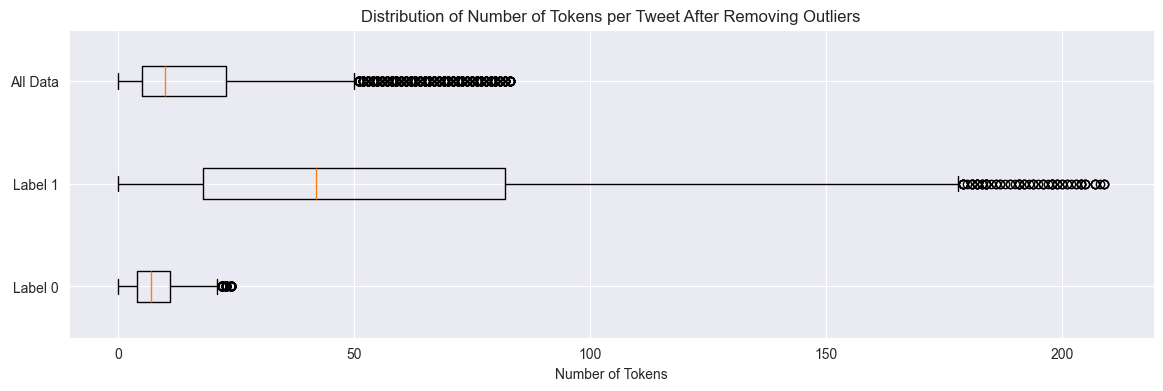

Combined Statistics After Removing Outliers:
     Statistic      Label 0      Label 1     All Data
0        count  4875.000000  3740.000000  7948.000000
1         mean     8.088615    55.705615    17.417967
2          std     5.235875    47.817387    18.375430
3          min     0.000000     0.000000     0.000000
4          25%     4.000000    18.000000     5.000000
5          50%     7.000000    42.000000    10.000000
6          75%    11.000000    82.000000    23.000000
7          max    24.000000   209.000000    83.000000
8  Lower Bound    -8.000000   -95.000000   -40.500000
9  Upper Bound    24.000000   209.000000    83.500000


In [17]:
# Detecting and removing outliers using IQR method
def remove_outliers(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data >= lower_bound) & (data <= upper_bound)], lower_bound, upper_bound

# Removing outliers for each label and all data
label_0_no_outliers, lb_0, ub_0 = remove_outliers(label_0)
label_1_no_outliers, lb_1, ub_1 = remove_outliers(label_1)
all_data_no_outliers, lb_all, ub_all = remove_outliers(all_data)

# Displaying the number of outliers detected and removed
outliers_label_0 = len(label_0) - len(label_0_no_outliers)
outliers_label_1 = len(label_1) - len(label_1_no_outliers)
outliers_all_data = len(all_data) - len(all_data_no_outliers)

print(f"Number of outliers detected and removed:")
print(f"Label 0: {outliers_label_0}")
print(f"Label 1: {outliers_label_1}")
print(f"All Data: {outliers_all_data}")

# Plotting token distribution after removing outliers
data_no_outliers = [label_0_no_outliers, label_1_no_outliers, all_data_no_outliers]
labels_no_outliers = ['Label 0', 'Label 1', 'All Data']

plt.figure(figsize=(14, 4))
plt.boxplot(data_no_outliers, labels=labels_no_outliers, vert=False)
plt.xlabel('Number of Tokens')
plt.title('Distribution of Number of Tokens per Tweet After Removing Outliers')
plt.show()

# Calculating statistics after removing outliers
label_0_stats_no_outliers = label_0_no_outliers.describe()
label_1_stats_no_outliers = label_1_no_outliers.describe()
all_data_stats_no_outliers = all_data_no_outliers.describe()

# Combined Statistics After Removing Outliers
stats_no_outliers_df = pd.DataFrame({
    'Statistic': label_0_stats_no_outliers.index.tolist() + ['Lower Bound', 'Upper Bound'],
    'Label 0': label_0_stats_no_outliers.values.tolist() + [lb_0, ub_0],
    'Label 1': label_1_stats_no_outliers.values.tolist() + [lb_1, ub_1],
    'All Data': all_data_stats_no_outliers.values.tolist() + [lb_all, ub_all]
})

print("Combined Statistics After Removing Outliers:")
print(stats_no_outliers_df)
